# Process Data From Scratch
|Fill in a module description here

# Mở Đầu

Trong bài viết này, tôi xin chia sẻ chi tiết cách mà tôi đã xây dựng 1 mô hình deep learning để phân loại ảnh trong bộ dữ liệu Fashion MNIST. Tôi sẽ chia bài viết này thành 2 phần, ở phần 1 này tôi sẽ chỉ sử dụng neural network. Và tập trung tối ưu mô hình nhất có thể để có được kết quả dự đoán cao nhất có thể.

# Giới Thiệu về Fashion MNIST

In [ ]:
from torchvision import datasets
# Download Data
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# Check the lengths of the datasets
print("Number of samples in the training set:", len(train_dataset))
print("Number of samples in the test set:", len(test_dataset))

Number of samples in the training set: 60000
Number of samples in the test set: 10000


Fashion-MNIST là một bộ dữ liệu chứa các hình ảnh về sản phẩm thời trang từ Zalando, bao gồm một bộ dữ liệu huấn luyện (training set) với 60,000 ví dụ và một bộ dữ liệu kiểm tra (test set) với 10,000 ví dụ.

In [ ]:
x = train_dataset.data
print(f"Shape: {x.shape}")
print(f"Min: {x.min().item()}")
print(f"Max: {x.max().item()}")

Shape: torch.Size([60000, 28, 28])
Min: 0
Max: 255


Mỗi hình ảnh có chiều cao 28 pixel và chiều rộng 28 pixel, tổng cộng có 784 pixel. Giá trị pixel này là một số nguyên nằm trong khoảng từ 0 đến 255.

In [ ]:
y = train_dataset.targets
print(f"Labels: {y.unique()}")

Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Mỗi ví dụ trong bộ dữ liệu huấn luyện và bộ dữ liệu kiểm tra được gán cho một trong các nhãn (label) sau:<br>
- 0 Áo phông/T-shirt<br>
- 1 Quần dài/Trouser<br>
- 2 Áo khoác len/Pullover<br>
- 3 Váy/Dress<br>
- 4 Áo khoác/Coat<br>
- 5 Dép xỏ ngón/Sandal<br>
- 6 Áo sơ mi/Shirt<br>
- 7 Giày thể thao/Sneaker<br>
- 8 Túi xách/Bag<br>
- 9 Giày bốt/Cổ cao/Ankle boot

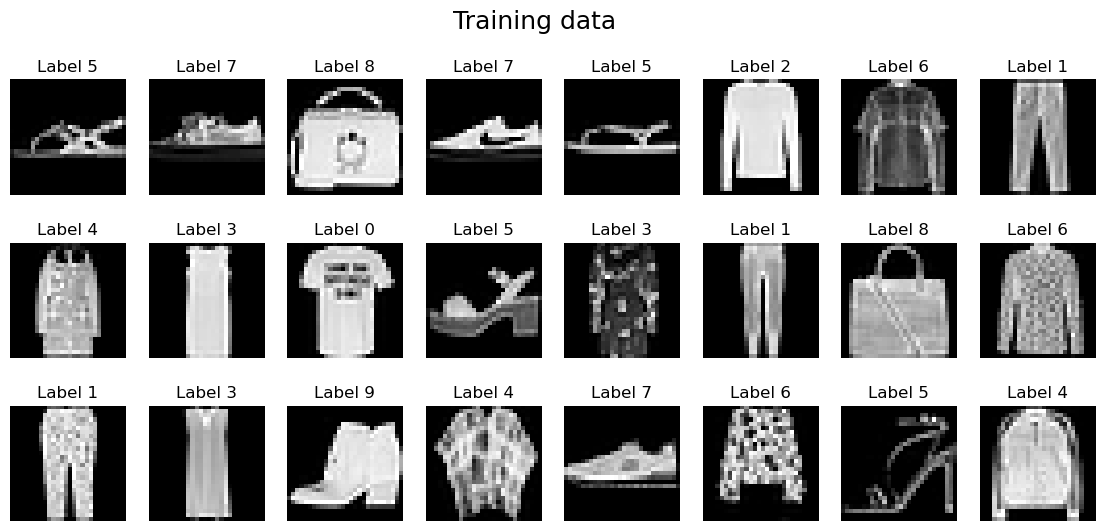

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 8, figsize = (14, 6))
for ax in axs.flatten():

  random_index = np.random.randint(len(x))

  ax.imshow(x[random_index, :], cmap = "gray")

  ax.set_title(f"Label {y[random_index].item()}")
  ax.axis("off")

plt.suptitle("Training data", fontsize = 18)
plt.show()

# Chia Dữ Liệu (Split data)

In [ ]:
labels, counts = np.unique(y, return_counts=True)

print("Checking Data Balance:")
for label, count in zip(labels, counts):
    print(f" Label: {label}, Count: {count}")


Checking Data Balance:
 Label: 0, Count: 6000
 Label: 1, Count: 6000
 Label: 2, Count: 6000
 Label: 3, Count: 6000
 Label: 4, Count: 6000
 Label: 5, Count: 6000
 Label: 6, Count: 6000
 Label: 7, Count: 6000
 Label: 8, Count: 6000
 Label: 9, Count: 6000


Dữ liệu đã được cân bằng, với mỗi nhãn (label) đều chứa đúng 6000 mẫu dữ liệu.

Kiểm tra độ cân bằng của dữ liệu là một bước quan trọng, tương tự như trong một bài thi có 10 câu hỏi và 4 phương án đáp án A, B, C, D. Trong ví dụ này, số lượng câu trả lời đúng cho mỗi phương án là 8 câu A, 1 câu B, 0 câu C và 1 câu D.

Hãy tưởng tượng bạn được phép làm bài thi này nhiều lần. Sau vài lần thực hiện, bạn sẽ nhận thấy một sự mất cân bằng trong số câu trả lời đúng cho mỗi phương án. Vì vậy, bạn có thể dễ dàng nhận ra xu hướng rằng câu A thường là câu trả lời đúng và bạn có thể chọn câu A cho tất cả các câu hỏi để đạt điểm số cao hơn.

Trong thực tế, việc kiểm tra độ cân bằng của dữ liệu giúp đảm bảo rằng mô hình deep learning được đào tạo trên dữ liệu đại diện cho tất cả các trường hợp, thay vì bị thiên vị theo một phương án hoặc lớp cụ thể.

In [ ]:
# Split data into train & valid set

## Calculate the number of validation samples per label
num_labels = len(np.unique(y))
val_pct = 0.2
val_samples_per_label = int(len(x) * val_pct / num_labels)

valid_indices = []

## Loop through each label
for label in np.unique(y):
    # Get the indices of samples belonging to this label
    label_indices = np.where(y == label)[0]
    
    # Randomly select a number of validation samples from this label
    sampled_indices = np.random.choice(label_indices, val_samples_per_label,replace=False)
    valid_indices.append(sampled_indices)

excluded_indices = np.concatenate(valid_indices)
mask = np.ones(len(x), dtype=bool)
mask[excluded_indices] = False

x_train = x[mask]
x_valid = x[excluded_indices]
y_train = y[mask]
y_valid = y[excluded_indices]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([48000, 28, 28]),
 torch.Size([48000]),
 torch.Size([12000, 28, 28]),
 torch.Size([12000]))

In [ ]:
val_labels, counts = np.unique(y_valid, return_counts=True)

print("Checking Valid Data Balance:")
for val_label, count in zip(val_labels, counts):
    print(f" Label: {val_label}, Count: {count}")

Checking Valid Data Balance:
 Label: 0, Count: 1200
 Label: 1, Count: 1200
 Label: 2, Count: 1200
 Label: 3, Count: 1200
 Label: 4, Count: 1200
 Label: 5, Count: 1200
 Label: 6, Count: 1200
 Label: 7, Count: 1200
 Label: 8, Count: 1200
 Label: 9, Count: 1200


Trong quá trình phát triển mô hình deep learning, việc chia dữ liệu thành hai phần: tập huấn luyện (train set) và tập xác thực (validation set), đồng thời duy trì sự cân bằng giữa các nhãn (labels) trong cả hai tập là rất quan trọng. Điều này tương tự như việc bạn ôn tập để chuẩn bị cho một kỳ thi

Hãy tưởng tượng bạn nhận được một đề cương ôn thi gồm 20 câu hỏi, trong đó mỗi câu có 4 phương án A, B, C, D và chỉ có một phương án đúng. Đề cương này đã được thiết kế sao cho cân bằng về số lượng câu trả lời đúng cho mỗi phương án. Trong trường hợp này, bạn có hai cách để ôn:

**Cách 1: Học thuộc lòng đáp án của đề cương**
Bạn có thể chọn học thuộc lòng đáp án cho từng câu hỏi trong đề cương. Tuy nhiên, khi tham gia kỳ thi thực tế, cách này thường dẫn đến điểm thấp, vì bạn có thể gặp những biến thể hoặc câu hỏi tương tự mà bạn chưa từng thấy trước đó. Bạn thiếu khả năng áp dụng kiến thức vào các tình huống mới và sâu hơn về nội dung thực sự của các câu hỏi.

**Cách 2: Học để hiểu cách trả lời câu hỏi một cách tổng quát**
Thay vì chỉ học thuộc lòng đáp án, bạn cố gắng hiểu sâu về kiến thức và logic đằng sau mỗi câu hỏi. Điều này giúp bạn phát triển khả năng áp dụng kiến thức vào các tình huống mới, bao gồm những biến thể của câu hỏi mà bạn có thể gặp trong kỳ thi thực tế. Khi tham gia kỳ thi, bạn sẽ tự tin hơn và có khả năng xử lý bất kỳ câu hỏi nào, giúp bạn đạt được điểm cao hơn.

Tương tự, việc chia dữ liệu thành tập huấn luyện và tập xác thực trong deep learning giúp mô hình học cách phân loại dữ liệu và tạo ra các dự đoán không chỉ dựa trên việc ghi nhớ dữ liệu huấn luyện. Nó giúp mô hình hiểu và tổng quát hóa kiến thức, từ đó cải thiện khả năng dự đoán trên dữ liệu mới và không biết trước (tập xác thực hoặc tập kiểm tra). Việc này giúp tránh overfitting, cải thiện hiệu suất của mô hình và làm cho nó trở nên đáng tin cậy hơn trong các ứng dụng thực tế.

In [ ]:
# Split data into train & valid set
from sklearn.model_selection import train_test_split

valid_pct = .2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_pct)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

val_labels, counts = np.unique(y_valid, return_counts=True)
print("Checking Valid Data Balance:")
for val_label, count in zip(val_labels, counts):
    print(f" Label: {val_label}, Count: {count}")

torch.Size([48000, 28, 28]) torch.Size([48000]) torch.Size([12000, 28, 28]) torch.Size([12000])
Checking Valid Data Balance:
 Label: 0, Count: 1192
 Label: 1, Count: 1223
 Label: 2, Count: 1180
 Label: 3, Count: 1205
 Label: 4, Count: 1188
 Label: 5, Count: 1199
 Label: 6, Count: 1190
 Label: 7, Count: 1209
 Label: 8, Count: 1195
 Label: 9, Count: 1219


Ơn trời, train_test_split thực sự đã làm cuộc sống của chúng ta trở nên dễ dàng và hạnh phúc hơn rất nhiều! 😃

# Chuẩn Hóa (Normalization)

Có ba phương pháp chuẩn hóa thường xuyên được sử dụng bao gồm: 

+ Min-Max Scaling

+ Z-Score (Standardization)

+ Robust Scaling. 

In [ ]:
def min_max_scale(data, a=0, b=1):
    # Calculate the minimum and maximum values of the data
    data_min = data.min()
    data_max = data.max()
    
    # Perform Min-Max Scaling
    data_norm = (data - data_min) / (data_max - data_min)
    
    # Rescale the data to the [a, b] range
    data_norm = a + data_norm * (b - a)
    
    return data_norm

**Công thức của Min-Max Scaling:**

Min-Max Scaling là một phương pháp chuẩn hóa dữ liệu được sử dụng để ánh xạ giá trị của một dữ liệu từ khoảng ban đầu [Min, Max] sang một khoảng mới [a, b], với a và b là giá trị cụ thể.

Công thức để scale giá trị x của một dữ liệu từ khoảng ban đầu [Min, Max] sang khoảng [0, 1] là:

$$ \text{Scaled Value} = \frac{{\text{x} - \text{Min}}}{{\text{Max} - \text{Min}}} $$

Để scale giá trị x của một dữ liệu về khoảng [a, b], công thức sẽ là:

$$ \text{Scaled Value} = a + \frac{{\text{x} - \text{Min}}}{{\text{Max} - \text{Min}}} \cdot (b - a) $$

Trong đó:

- **Scale Value**: Giá trị sau khi chuẩn hóa của dữ liệu theo phương pháp Min-Max Scaling.

- **x**: Giá trị ban đầu của dữ liệu.

- **Min**: Giá trị nhỏ nhất trong khoảng ban đầu.

- **Max**: Giá trị lớn nhất trong khoảng ban đầu.

- **a**: Giá trị nhỏ nhất trong khoảng mới (thường là 0).

- **b**: Giá trị lớn nhất trong khoảng mới (thường là 1).


In [ ]:
def z_score(data):
    # Calculate the mean and standard deviation of the input data
    data_mean = data.mean()
    data_std = data.std(ddof=1)
    
    # Perform Z-score (standardization) on the data
    data_norm = (data - data_mean) / data_std

    return data_norm

**Công thức của Z-score (Standardization):**

Z-score (hoặc Standardization) là một phương pháp chuẩn hóa dữ liệu được sử dụng để biến đổi giá trị của một dữ liệu sao cho nó có giá trị trung bình (mean) bằng 0 và độ lệch chuẩn (standard deviation) bằng 1.

Công thức để tính Z-score cho một giá trị x trong dữ liệu là:

$$ \text{Z-score} = \frac{{\text{x} - \text{Mean}}}{{\text{Standard Deviation}}} $$

Trong đó:

- **Z-score**: Giá trị Z-score của dữ liệu sau khi chuẩn hóa.

- **x**: Giá trị ban đầu của dữ liệu.

- **Mean**: Giá trị trung bình của dữ liệu.

- **Standard Deviation**: Độ lệch chuẩn của dữ liệu.


In [ ]:
def robust_scale(data):
    # Calculate the median and interquartile range (IQR) of the data
    data_median = np.median(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    
    # Perform Robust Scaling
    data_scaled = (data - data_median) / iqr
    
    return data_scaled

**Công thức của Robust Scaling:**

Robust Scaling (hoặc Robust Standardization) là một phương pháp chuẩn hóa dữ liệu được sử dụng để biến đổi giá trị của một dữ liệu sao cho nó có tính ổn định đối với sự hiện diện của các outliers. Phương pháp này sử dụng median và khoảng biến thiên (IQR - Interquartile Range) của dữ liệu để thực hiện chuẩn hóa.

Công thức để tính Robust Scaling cho một giá trị x trong dữ liệu là:

$$ \text{Robust Scaled} = \frac{{\text{x} - \text{Median}}}{{\text{IQR}}} $$

Trong đó:

- **Robust Scaled**: Giá trị sau khi chuẩn hóa của dữ liệu theo phương pháp Robust Scaling.

- **x**: Giá trị ban đầu của dữ liệu.

- **Median**: Giá trị trung vị (median) của dữ liệu.

- **IQR**: Khoảng biến thiên giữa phân vị 25% (Q1) và phân vị 75% (Q3) của dữ liệu.

**Lựa chọn phương pháp normalization**

Việc lựa chọn phương pháp chuẩn hóa dữ liệu phụ thuộc vào tính chất của dữ liệu và mục tiêu cụ thể của dự án. Trong trường hợp dự án Fashion MNIST, dữ liệu là hình ảnh, do đó tôi đã chọn thử nghiệm **hai** phương pháp chuẩn hóa: **Min-Max Scaling** và **Robust Scaling**. 

Lý do là Min-Max Scaling đơn giản chỉ định khoảng giá trị cho dữ liệu mà không thay đổi tính chất của hình ảnh ban đầu. Robust Scaling cũng phù hợp vì nó sử dụng median thay vì giá trị trung bình, nên nó có khả năng xử lý tốt với các bộ dữ liệu không tuân theo phân phối Gaussian. Tuy nhiên, Z-Score sử dụng mean nên không phải lúc nào cũng phù hợp cho các dữ liệu không tuân theo phân phối Gaussian.

In [ ]:
x_train_norm = min_max_scale(x_train)
x_valid_norm = min_max_scale(x_valid)
print(f"Train Data: {x_train_norm.shape}, Min: {x_train_norm.min()}, Max: {x_train_norm.max()}")
print(f"Valid Data: {x_valid_norm.shape}, Min: {x_valid_norm.min()}, Max: {x_valid_norm.max()}")

Train Data: torch.Size([48000, 28, 28]), Min: 0.0, Max: 1.0
Valid Data: torch.Size([12000, 28, 28]), Min: 0.0, Max: 1.0


Trước hết, tôi sẽ bắt đầu bằng việc chuẩn hóa dữ liệu bằng phương pháp Min-Max Scaling. Sau đó, khi tiến đến giai đoạn tối ưu hóa mô hình để tăng độ chính xác trong việc dự đoán dữ liệu xác thực (Validation Data), tôi sẽ quay lại và thử nghiệm với Robust Scaling để xem liệu có cải thiện độ chính xác của mô hình hay không.

# Tải Dữ Liệu (Load Data)

Trong quá trình tải dữ liệu và huấn luyện mô hình Deep Learning, có ba khái niệm quan trọng cần hiểu:

1. **Batches:**

- Khi bạn tải toàn bộ dữ liệu vào mô hình để tính gradient và cập nhật trọng số, chúng ta gọi đó là "Batches." Trong cách tiếp cận này, toàn bộ dữ liệu được sử dụng một lần duy nhất trong mỗi vòng lặp huấn luyện. Trong trường hợp này, **batch size** bằng với chiều dài của dữ liệu.

2. **Mini-Batches:**

- Khi bạn tải một phần nhỏ của dữ liệu, với kích thước nằm giữa một mẫu đơn và toàn bộ dữ liệu, chúng ta gọi đó là "Mini-Batches." 
- Trong Mini-Batches, bạn chia dữ liệu thành các nhóm nhỏ có kích thước cố định, gọi là **"batch size"**. Mỗi batch trong đó chứa một số lượng mẫu dữ liệu được sử dụng để tính gradient và cập nhật trọng số.

3. **Stochastic Gradient Descent (SGD)**:

- SGD là một phiên bản đặc biệt của mini-batches với **batch size** bằng 1, nghĩa là mỗi mẫu dữ liệu đều được sử dụng để tính gradient và cập nhật trọng số mô hình riêng lẻ.

Lựa chọn giữa Batches, Mini-Batches và SGD phụ thuộc vào tài nguyên và mục tiêu huấn luyện của bạn. Chúng có ảnh hưởng đến tốc độ học của mô hình và khả năng tổng quát hóa.

In [ ]:
def load_data(x_tensor, y_tensor, batch_size, drop_last=False, test=False):
    num_samples = len(x_tensor)
    
    mini_batches = []
    
    if not test:
        # Shuffle the data if it's the training set
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        x_tensor = x_tensor[indices]
        y_tensor = y_tensor[indices]
        
    for i in range(0, num_samples, batch_size):
        # Handling the last mini-batch
        if i + batch_size > num_samples:
            # If not dropping the last mini-batch
            if not drop_last:
                batch_x = x_tensor[i:num_samples]
                batch_y = y_tensor[i:num_samples]
        
        # For other mini-batches
        else:
            batch_x = x_tensor[i:i + batch_size]
            batch_y = y_tensor[i:i + batch_size]
        
        mini_batches.append((batch_x, batch_y))
    
    print(f"Total Mini-Batches: {len(mini_batches)}")
    for i, (x, y) in enumerate(mini_batches):
        if i == 0:
            print(f"Shape of Each Mini-Batch: {x.shape}")
            print("")
            break
    
    return mini_batches

batch_size = 32
train_loader = load_data(x_train, y_train, batch_size=batch_size, drop_last=True)
valid_loader = load_data(x_valid, y_valid, batch_size=batch_size, test=True)

Total Mini-Batches: 1500
Shape of Each Mini-Batch: torch.Size([32, 28, 28])

Total Mini-Batches: 375
Shape of Each Mini-Batch: torch.Size([32, 28, 28])



Đối với dự án này, và thực tế là hầu hết các dự án khác, việc sử dụng **Mini-Batches** là phương pháp phổ biến và khả thi. Lý do là Mini-Batches cho phép tận dụng sức mạnh của **GPU** và giúp tiết kiệm đáng kể thời gian huấn luyện mô hình. Do đó, quá trình load data cũng trở thành một phần quan trọng và không thể thiếu trong quá trình xây dựng mô hình Deep Learning.

Trong tập dữ liệu huấn luyện (train set), việc trộn (shuffle) dữ liệu là bước không thể thiếu để mô hình học một cách tổng quan hơn, như việc khuấy đều mọi thứ trước khi nấu một món ngon. Trong phương pháp Mini-Batches, việc quyết định có nên loại bỏ dữ liệu cuối cùng (drop_last) hay không phụ thuộc vào số lượng mẫu dữ liệu có sẵn trong dự án của bạn. Với dự án này có 60000 mẫu dữ liệu, việc loại bỏ một lượng nhỏ ở mini-batches cuối cùng không ảnh hưởng đáng kể đến sự hiệu quả của mô hình.

Tuy nhiên, đối với tập dữ liệu kiểm tra, bạn không cần phải lo lắng về việc trộn dữ liệu hoặc suy nghĩ về việc có bỏ dữ liệu ở mini-batches cuối cùng hay không. Đơn giản là bạn cứ tải nó vào các Mini-Batches để tối ưu hóa tính toán cho mô hình, như việc thưởng thức một bữa ăn ngon mà không cần phải nấu lại từ đầu." 😄

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def load_data(x_tensor, y_tensor, batch_size, test):
    data = TensorDataset(x_tensor, y_tensor)
    
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=not test, drop_last=not test)

    print(f"Total Mini-Batches: {len(data_loader)}")
    for i, (x, y) in enumerate(data_loader):
        if i == 0:
            print(f"Shape of Each Mini-Batch: {x.shape}")
            print("")
            break
    return data_loader

batch_size = 32
train_loader = load_data(x_train, y_train, batch_size=batch_size, test = False)
valid_loader = load_data(x_valid, y_valid, batch_size=batch_size, test=True)

Total Mini-Batches: 1500
Shape of Each Mini-Batch: torch.Size([32, 28, 28])

Total Mini-Batches: 375
Shape of Each Mini-Batch: torch.Size([32, 28, 28])



Giờ đây, quá trình tải dữ liệu (load data) trở nên cực kỳ đơn giản. Chỉ cần đưa x và y vào TensorDataset, sau đó sử dụng DataLoader với một số tùy chỉnh cho tập dữ liệu huấn luyện và kiểm tra, và bạn đã có mọi thứ cần thiết cho việc load data. Thật tuyệt vời!" 😄